# dcurves Tutorial

In [33]:
!python --version


Python 3.9.12


Install dcurves On The Terminal/Command Line

In [31]:
!pip install dcurves==1.0.4

Install dcurves Functions

In [12]:
from dcurves import dca, plot_graphs

Import Other Packages Used In This Tutorial

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import lifelines
# Display plots in notebook
%matplotlib inline 

Import Cancer Simulation Dataset

In [14]:
df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')

Create A Generalized Linear Model

In [15]:
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod1_results = mod1.fit()

mod1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      748
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.30
Date:                Mon, 23 Jan 2023   Deviance:                       602.60
Time:                        13:54:40   Pearson chi2:                     750.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006445
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9227      0.119    -16.163      0.000      -2.156      -1.690
famhistory     0.5899      0.258      2.282      0.022       0.083       1.097
==============================================================================
"""

Run DCA With Cancer Outcome and Famhistory Predictor/Model

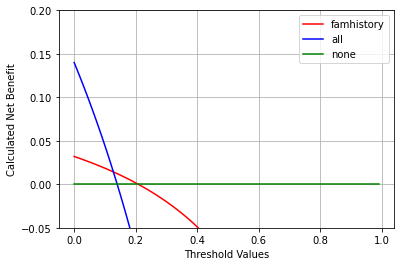

In [16]:
dca_famhistory_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory']
    )

plot_graphs(
    plot_df=dca_famhistory_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

Run DCA With Cancer Outcome and Famhistory Predictor/Model with Abridged Thresholds

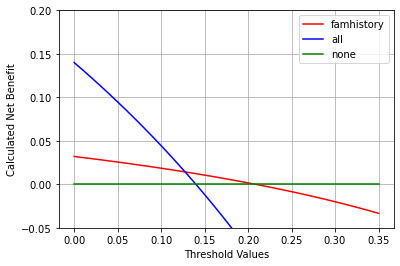

In [17]:
dca_famhistory2_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory'],
        thresholds=np.arange(0, 0.36, 0.01),
    )

plot_graphs(
    plot_df=dca_famhistory2_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

Run Multivariate Model and Print Model Summary

In [18]:
mod2 = sm.GLM.from_formula('cancer ~ marker + age + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod2_results = mod2.fit()

mod2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.89
Date:                Mon, 23 Jan 2023   Deviance:                       427.79
Time:                        13:54:45   Pearson chi2:                     743.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.0703      2.211     -9.984      0.000     -26.403     -17.738
marker         0.9783      0.118      8.276      0.000       0.747       1.210
age            0.2820      0.031      9.040      0.000       0.221       0.343
famhistory     0.8652      0.308      2.807      0.005       0.261       1.469
==============================================================================
"""

Following 3 Steps Coming Soon! 
- build multivariable logistic regression model
- summarize model
- add predicted values from model to data set

Run DCA on Multivariable Model

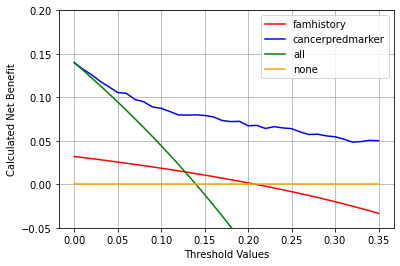

In [19]:
dca_multi_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory', 'cancerpredmarker'],
        thresholds=np.arange(0,0.36,0.01)
    )

plot_graphs(
    plot_df=dca_multi_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green', 'orange']
)

Smooth #1

In [20]:
# Coming Soon

Smooth #2

In [21]:
# Coming Soon

Published Model

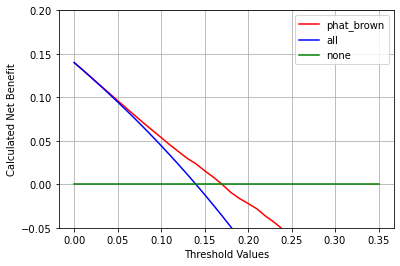

In [22]:
df_cancer_dx['logodds_brown'] = 0.75 * df_cancer_dx['famhistory'] + 0.26*df_cancer_dx['age'] - 17.5
df_cancer_dx['phat_brown'] = np.exp(df_cancer_dx['logodds_brown']) / (1 + np.exp(df_cancer_dx['logodds_brown']))

dca_pub_model_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['phat_brown'],
      thresholds=np.arange(0,0.36,0.01),
  )

plot_graphs(
    plot_df=dca_pub_model_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green']
)

Joint Calculations

In [23]:
df_cancer_dx['high_risk'] = np.where(df_cancer_dx['risk_group'] == "high", 1, 0)

df_cancer_dx['joint'] = np.where((df_cancer_dx['risk_group'] == 'high') |
                                 (df_cancer_dx['cancerpredmarker'] > 0.15), 1, 0)

df_cancer_dx['conditional'] = np.where((df_cancer_dx['risk_group'] == "high") |
                                       ((df_cancer_dx['risk_group'] == "intermediate") &
                                        (df_cancer_dx['cancerpredmarker'] > 0.15)), 1, 0)


Perform DCA On Joint Data

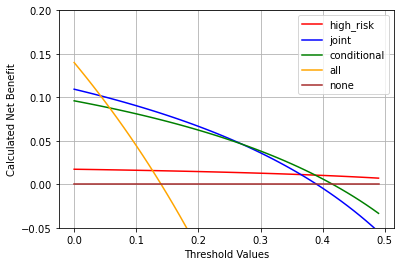

In [26]:
  dca_joint_df = \
      dca(
          data=df_cancer_dx,
          outcome='cancer',
          modelnames=['high_risk', 'joint', 'conditional'],
          thresholds=np.arange(0, 0.5, 0.01)
      )
  
  plot_graphs(
      plot_df=dca_joint_df,
      graph_type='net_benefit',
      y_limits=[-0.05, 0.2],
      color_names=['red', 'blue', 'green', 'orange', 'brown']
  )

Run DCA On a Simple Harms Per Model Case

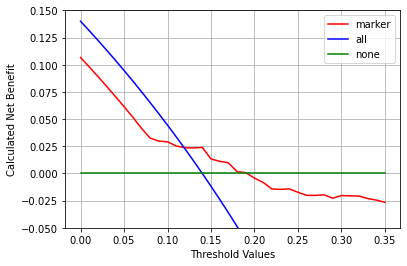

In [27]:
dca_harm_simple_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['marker'],
      thresholds=np.arange(0, 0.36, 0.01),
      harm={'marker': 0.0333},
      models_to_prob=['marker']
  )

plot_graphs(
    plot_df=dca_harm_simple_df,
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green'],
    y_limits=[-0.05, 0.15]
)

Run DCA On a Harms Per Model Case

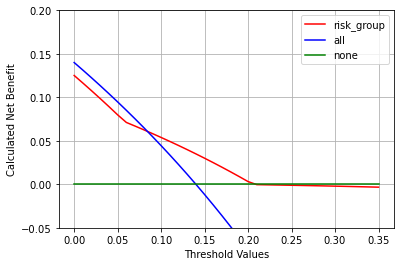

In [30]:
harm_marker = 0.0333
df_cancer_dx
harm_conditional = (df_cancer_dx['risk_group'] == "intermediate").mean() * harm_marker
# df_cancer_dx['risk_group']

dca_harm_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['risk_group'],
      models_to_prob=['risk_group'],
      thresholds=np.arange(0, 0.36, 0.01),
      harm={'risk_group': harm_conditional}
  )

plot_graphs(
    plot_df=dca_harm_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

In [29]:
harm_conditional

NameError: name 'harm_conditional' is not defined